STEP 1: Loading Dataset...
 - Data Loaded. Shape: (891, 8)
 - Checking Missing Values:
survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
dtype: int64

STEP 2: Building Preprocessing Pipeline...

STEP 3: Splitting & Training...
 - Model Training Complete.

STEP 4: Evaluating Performance...

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

Accuracy Score: 80.45%
ROC-AUC Score:  0.8427


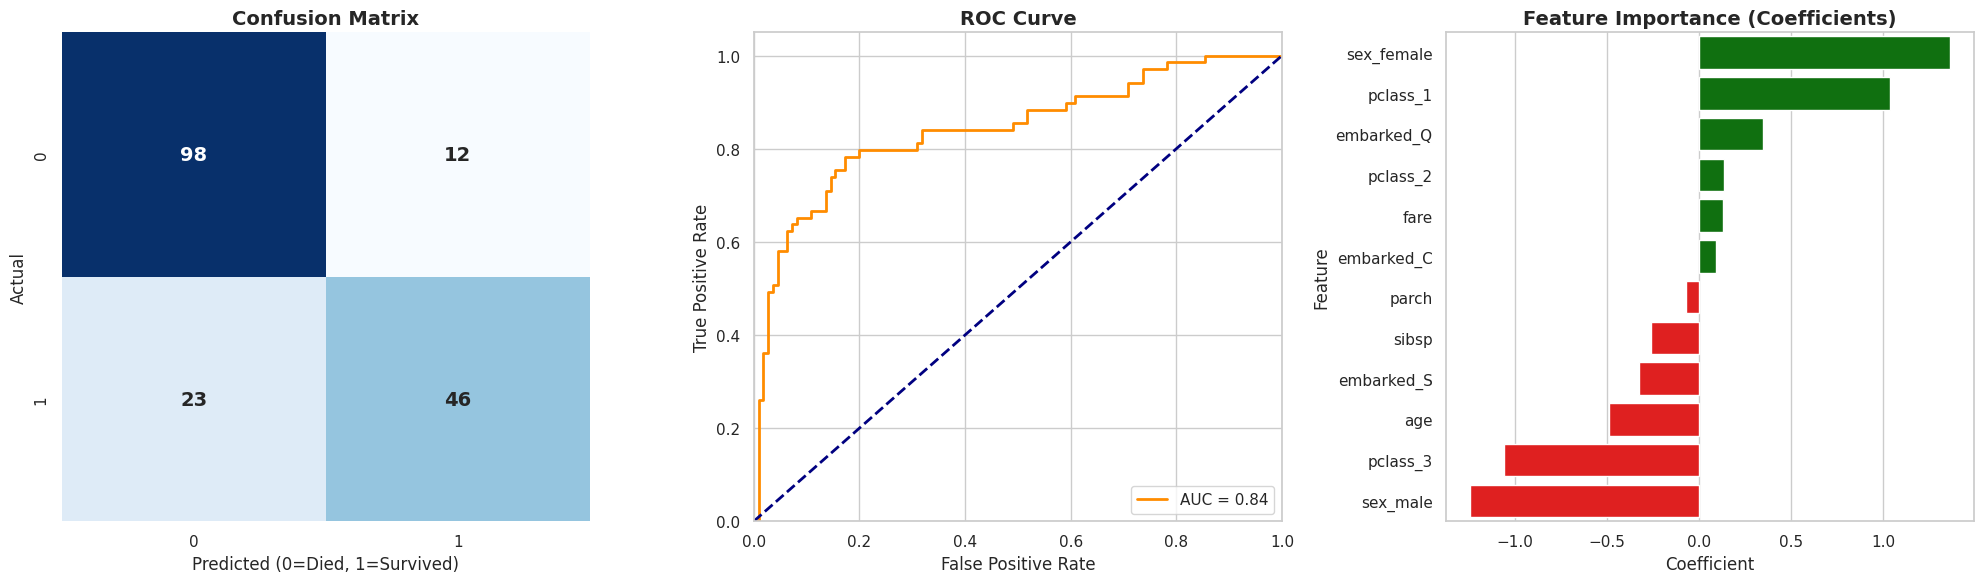

In [2]:
# Logistic Regression – Titanic Survival Prediction
# Dataset: Seaborn 'titanic' (Built-in)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report, roc_auc_score
)

# SETTING VISUAL THEME
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (20, 6)

def load_and_explore_data():
    """
    Loads the Titanic dataset and performs initial cleaning.
    """
    print("STEP 1: Loading Dataset...")
    # Load directly from Seaborn
    df = sns.load_dataset('titanic')

    # Selecting only relevant features for prediction
    relevant_cols = ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
    df = df[relevant_cols]

    print(f" - Data Loaded. Shape: {df.shape}")
    print(" - Checking Missing Values:")
    print(df.isnull().sum())

    return df

def build_preprocessing_pipeline():
    """
    Creates a Scikit-Learn ColumnTransformer to handle:
    1. Missing Values (Imputation)
    2. Scaling (StandardScaler)
    3. Categorical Encoding (OneHotEncoder)
    """
    print("\nSTEP 2: Building Preprocessing Pipeline...")

    # 1. Numeric Features: Age, Fare, SibSp, Parch
    # Strategy: Impute missing with Median -> Scale data
    numeric_features = ['age', 'fare', 'sibsp', 'parch']
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # 2. Categorical Features: Sex, Embarked, Pclass
    # Strategy: Impute missing with Mode -> OneHot Encode
    categorical_features = ['sex', 'embarked', 'pclass']
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine both into a single processor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    return preprocessor

def train_model(df, preprocessor):
    """
    Splits data and trains the Logistic Regression model within a Pipeline.
    """
    print("\nSTEP 3: Splitting & Training...")

    X = df.drop('survived', axis=1)
    y = df['survived']

    # Stratify ensures we keep the same % of survivors in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Create Full Pipeline: Preprocessor -> Model
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ])

    model.fit(X_train, y_train)
    print(" - Model Training Complete.")

    return model, X_test, y_test

def evaluate_performance(model, X_test, y_test):
    """
    Calculates metrics and generates the Evaluation Dashboard.
    """
    print("\nSTEP 4: Evaluating Performance...")

    # Generate Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] # Probability for ROC Curve

    # Text Metrics
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2%}")
    # Fix: Calculate ROC AUC properly
    roc_score = roc_auc_score(y_test, y_prob)
    print(f"ROC-AUC Score:  {roc_score:.4f}")

    # VISUALIZATION DASHBOARD
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Plot 1: Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False,
                annot_kws={"size": 14, "weight": "bold"})
    axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted (0=Died, 1=Survived)')
    axes[0].set_ylabel('Actual')

    # Plot 2: ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")

    # Plot 3: Feature Importance
    # Extract feature names from the OneHotEncoder to map them correctly
    model_step = model.named_steps['classifier']
    preprocessor_step = model.named_steps['preprocessor']

    # Get names for categorical columns after OneHotEncoding
    cat_names = preprocessor_step.transformers_[1][1]['onehot'].get_feature_names_out(['sex', 'embarked', 'pclass'])
    num_names = ['age', 'fare', 'sibsp', 'parch']
    feature_names = np.r_[num_names, cat_names]

    # Create DataFrame for plotting
    coeffs = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model_step.coef_[0]
    }).sort_values(by='Coefficient', ascending=False)

    # FIX: Add a Type column to handle coloring cleanly (removes FutureWarning)
    coeffs['Impact'] = ['Positive' if x > 0 else 'Negative' for x in coeffs['Coefficient']]

    # Using 'hue' and a specific palette dictionary to satisfy new Seaborn rules
    color_map = {'Positive': 'green', 'Negative': 'red'}
    sns.barplot(x='Coefficient', y='Feature', data=coeffs, hue='Impact',
                palette=color_map, ax=axes[2], dodge=False)
    axes[2].legend_.remove() # Hide redundant legend
    axes[2].set_title('Feature Importance (Coefficients)', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

# MAIN EXECUTION
if __name__ == "__main__":
    # 1. Load Data
    data = load_and_explore_data()

    # 2. Build Pipeline
    preprocessing_pipeline = build_preprocessing_pipeline()

    # 3. Train
    lr_model, X_test_set, y_test_set = train_model(data, preprocessing_pipeline)

    # 4. Evaluate & Visualize
    evaluate_performance(lr_model, X_test_set, y_test_set)